In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
#from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec
from mcmodels.core.utils import get_injection_hemisphere_id

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [11]:
def get_ccf_data(cache, experiment_id):

    eid_data = ExperimentData(experiment_id)
    eid_data.data_quality_mask = cache.get_data_mask(experiment_id)[0]
    eid_data.injection_signal = cache.get_injection_density(experiment_id)[0]
    eid_data.injection_fraction = cache.get_injection_fraction(experiment_id)[0]
    eid_data.projection_signal = cache.get_projection_density(experiment_id)[0]
    return(eid_data)
#     return {
#         "data_quality_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_signal" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_signal" : cache.get_projection_density(experiment_id)[0]
#     }

def get_connectivity_data(cache, structure_ids, experiments_exclude, remove_injection = False):

    connectivity_data = ConnectivityData()
    for sid in structure_ids:
        print(sid)
        sid_data = StructureData(sid)
        #deprecated language
        model_data = ModelData(cache, sid)
        sid_data.eids = model_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=None)
        for eid in sid_data.eids:
            
            eid_data = get_ccf_data(cache, eid)#ExperimentData(eid)
            eid_data.data_mask_tolerance = .5
            #ccf_data = get_ccf_data(cache, eid)
            eid_data.injection_signal_true = eid_data.injection_signal * eid_data.injection_fraction
            if remove_injection == True:
                pass #remove injection fraction from projection
            #injection_signal should = projection_signal in some locations (nonzero)
            #why do we use partial?
            #mask_func = partial(_mask_data_volume,data_mask=eid_data.data_mask,tolerance=eid_data.data_mask_tolerance)
            eid_data.injection_qmasked  = _mask_data_volume(eid_data.injection_signal_true,eid_data.data_quality_mask,eid_data.data_mask_tolerance)
            eid_data.projection_qmasked  = _mask_data_volume(eid_data.projection_signal,eid_data.data_quality_mask,eid_data.data_mask_tolerance) #mask_func(eid_data.projection_signal) 
            #eid_data.centroid = compute_centroid(eid_data.injection_qmasked)
            sid_data.experiment_datas[eid] = eid_data
        connectivity_data.structure_datas[sid] = sid_data
    return(connectivity_data)

def get_data_matrices(connectivity_data):
    
    structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        connectivity_data.structure_datas[sid].injection_mask = Mask.from_cache(cache,structure_ids=[sid],hemisphere_id=2)
        connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)
        for eid in experiment_ids:
            connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
            connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)
        connectivity_data.structure_datas[sid].injections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec for eid in connectivity_data.structure_datas[sid].eids])
        connectivity_data.structure_datas[sid].centroids = np.asarray([connectivity_data.structure_datas[sid].experiment_datas[eid].centroid for eid in connectivity_data.structure_datas[sid].eids])
        
        
    return(connectivity_data)


def get_regionalized_normalized_data(connectivity_data, cache, source_order, ipsi_key, contra_key): #experiments_minor_structures):
    '''
    :param msvds: Class dictionary holding data
    :param cache: AllenSDK cache
    :param source_order: Source key (tautologically ipsilateral due to hemisphere mirroring)
    :param ipsi_key: Ipsilateral target key
    :param contra_key:  Contralateral target key
    :return: msvds: Class dictionary holding average data
    '''
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        # print()
        structure_data = connectivity_data.structure_datas[sid]
        #nexp = msvd.projections.shape[0]

        #minor_structures = np.unique(experiments_minor_structures[sid])
        #nmins = len(minor_structures)

        projections = structure_data.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        structure_data.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        structure_data.reg_proj_vcount_norm = reg_proj_vcount_norm
        structure_data.reg_proj_vcount_norm_renorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_proj_vcount_norm, axis=1), 1)
        
        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=source_order)
        source_regions, source_counts = nonzero_unique(source_key, return_counts=True)

        injections = structure_data.injections
        reg_ipsi_inj = unionize(injections, source_key)
        structure_data.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_counts[np.newaxis, :])
        structure_data.reg_inj_vcount_norm = reg_inj_vcount_norm
        
        structure_data.reg_proj_vcount_norm_injnorm = reg_proj_vcount_norm / np.expand_dims(np.linalg.norm(reg_inj_vcount_norm, axis=1), 1)
        connectivity_data.structure_datas[sid] = structure_data
        #msvd.reg_proj_vcountnorm_totalnorm =

    return (connectivity_data)

# def get_normalized_data(connectivity_data, normalization = None):

#     structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
#     for sid in structure_ids:
#         if normalization == None:
#             pass
#         if normalization == 'injection':
#             nc = np.sum(connectivity_data.structure_datas[sid].injections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc
#         if normalization == 'total':
#             nc = np.sum(conn_data[sid].projections, axis = 1)
#             connectivity_data.structure_datas[sid].projection_normed = connectivity_data.structure_datas[sid].projections / nc

#     return(connectivity_data)


def compute_centroid(injection_density):
    """Computes centroid in index coordinates.

    Parameters
    ----------
    injection_density : array, shape (x_ccf, y_ccf, z_ccf)
        injection_density data volume.

    Returns
    -------
        centroid of injection_density in index coordinates.
    """
    nnz = injection_density.nonzero()
    coords = np.vstack(nnz)

    return np.dot(coords, injection_density[nnz]) / injection_density.sum()

def get_cre_status(data_info, connectivity_data):
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    exps = np.asarray(data_info.index.values , dtype = np.int)
    creline = {}
    for sid in major_structure_ids:
        experiment_ids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        nexp = len(experiment_ids)
        creline[sid] = np.zeros(nexp, dtype = object)
        for i in range(len(experiment_ids)):
            index = np.where(exps == experiment_ids[i])[0][0]
            creline[sid][i] = data_info['transgenic-line'].iloc[index]
    return(creline)


In [12]:

    
# #get dictionary of minor structures for each experiment in each major division
# #major division segregation is legacy code but convenient for fast cross validation in major division model
# experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

# #get leaves in ontological order.  Where leafs don't exist, uses summary structure
# ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

# #Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
# key = list(msvd.experiments.keys())[0]

# #Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
# #contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
# #ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
# contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# #get average intensities of projection structures given ipsi and contra keys
# source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
# msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

# #wt_2ormore = get_wt_inds(creline)

In [14]:
class ConnectivityData():
    
    def __init__(self):
        self.structure_datas = {}    
    
    def get_injection_hemisphere_ids(self):
        
        structure_datas = self.structure_datas
        
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_injection_hemisphere_ids()
            
        self.structure_datas = structure_datas
        
        
    def align(self):
        
        structure_datas= self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].align()
        self.structure_datas = structure_datas

    def get_centroids(self):
        
        structure_datas = self.structure_datas
        
        for sid in list(structure_datas.keys()):
            structure_datas[sid].get_centroids()
            
        self.structure_datas = structure_datas
        
class StructureData():
    
    def __init__(self, sid):
        self.experiment_datas = {}
        
    def get_injection_hemisphere_ids(self):   
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
             experiment_datas[eid].injection_hemisphere_id = get_injection_hemisphere_id(experiment_datas[eid].injection_qmasked, majority=True)
        self.experiment_datas = experiment_datas
        
    def align(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            if experiment_datas[eid].injection_hemisphere_id == 1:
                experiment_datas[eid].flip()
        self.experiment_datas = experiment_datas

    def get_centroids(self):
        
        experiment_datas = self.experiment_datas
        
        for eid in list(experiment_datas.keys()):
            experiment_datas[eid].centroid = compute_centroid(experiment_datas[eid].injection_qmasked)
        self.experiment_datas = experiment_datas        
        
class ExperimentData():
    
    def __init__(self, eid):
        2+2
    
    #def get_injection_hemisphere():
        
        
    def flip(self):
        """Reflects experiment along midline.

        Returns
        -------
        self - flipped experiment
        """

        self.injection_qmasked = self.injection_qmasked[..., ::-1]
        self.projection_qmasked = self.projection_qmasked[..., ::-1]
        self.injection_signal = self.injection_signal[..., ::-1]
        self.projection_signal = self.projection_signal[..., ::-1]
        self.injection_signal_true = self.injection_signal_true[..., ::-1]
        #self.projection_signal_true = self.projection_signal_true[..., ::-1]
        self.injection_fraction = self.injection_fraction[..., ::-1]
        self.data_quality_mask = self.data_quality_mask[...,::-1]
        
        #return self        

def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
    """Masks a given data volume in place.

    Parameters
    ----------
    data_volume : array, shape (x_ccf, y_ccf, z_ccf)
        Data volume to be masked.

    data_mask : array, shape (x_ccf, y_ccf, z_ccf)
        data_mask for given experiment (values in [0,1])
        See allensdk.core.mouse_connectivity_cache for more info.

    tolerance : float, optional (default=0.0)
        tolerance with which to define bad voxels in data_mask.


    Returns
    -------
    data_volume
        data_volume parameter masked in place.

    """
    if data_volume.shape != data_mask.shape:
        raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
                         "shape!" % (data_volume.shape, data_mask.shape))

    # mask data volume
    data_volume[data_mask < tolerance] = 0.0

    return data_volume


def get_summarystructure_dictionary(connectivity_data, data_info):
    summarystructure_dictionary = {}
    major_structure_ids = np.asarray(list(connectivity_data.structure_datas.keys()))
    for sid in major_structure_ids:
        eids = np.asarray(list(connectivity_data.structure_datas[sid].experiment_datas.keys()))
        summarystructure_dictionary[sid] = get_minorstructures(eids, data_info)
    return (summarystructure_dictionary)


def get_leaves_ontologicalorder(connectivity_data, ontological_order):
    '''

    :param msvd:
    :param ontological_order:
    :return: The leaf order associated with the 'ontological_order' of summary structures
    '''
    sid0 = list(connectivity_data.structure_datas.keys())[0]
    #eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
    levs = connectivity_data.structure_datas[sid0].projection_mask.reference_space.structure_tree.child_ids(
        ontological_order)
    flat_list = np.asarray([item for sublist in levs for item in sublist])

    nss = len(levs)
    leavves = np.asarray([])
    for i in range(nss):
        if len(levs[i]) > 0:
            leavves = np.append(leavves, levs[i])
        else:
            leavves = np.append(leavves, ontological_order[i])
    return (leavves)


In [15]:
#first, download data and apply injection fraction and data quality masks
connectivity_data = get_connectivity_data(cache, major_structure_ids[4:5], experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
#
#get_injection_hemisphere_id
#connectivity_data[sid].experiments[eid].flip()


315


In [16]:
connectivity_data.get_centroids()
#then apply the projection and injection masks to get regionalized data
connectivity_data = get_data_matrices(connectivity_data)

In [17]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#key = eid0

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument


In [ ]:
#         sid = 315
#         eid = 293472335
#         connectivity_data.structure_datas[sid].projection_mask = Mask.from_cache(cache,structure_ids=default_structure_ids, hemisphere_id=3)

#         connectivity_data.structure_datas[sid].experiment_datas[eid].injection_vec = connectivity_data.structure_datas[sid].injection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked)
#         connectivity_data.structure_datas[sid].experiment_datas[eid].projection_vec = connectivity_data.structure_datas[sid].projection_mask.mask_volume(connectivity_data.structure_datas[sid].experiment_datas[eid].projection_qmasked)


In [ ]:
#connectivity_data.structure_datas[sid].projections = np.asarray([connectivity_data[sid].experiments[eid].projection_vec for eid in connectivity_data[sid].eids])


In [18]:
#then regionalize and normalize data (constant scaling of normalize then regionalize)
#connectivity_data = get_normalized_data(connectivity_data, normalization = None)
connectivity_data = get_regionalized_normalized_data(connectivity_data, cache, ontological_order, ipsi_targetkey, contra_targetkey)

In [19]:
#get dictionaries of creline and leaf by experiment

creline = get_cre_status(data_info, connectivity_data)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)


In [20]:
sid = 315
#leafs[315]

In [21]:
#creline[315]
m = 4

In [22]:
list(connectivity_data.structure_datas[315].experiment_datas.keys())[40]

293472335

In [23]:
np.intersect1d(np.where(leafs[315] == ai_map['VISp4'])[0], np.where(creline[315] == 'Cux2-IRES-Cre'))

array([  40,   42,   76,  126,  155,  200,  245,  333,  534,  583,  605,
        682,  889, 1008])

In [31]:
np.intersect1d(np.where(leafs[315] == ai_map['VISp6a'])[0], np.where(creline[315] == 'Ntsr1-Cre_GN220'))

array([ 111,  303,  316,  357,  411,  473,  487,  521,  648,  698,  898,
        933, 1044])

Text(0.5, 1, 'Isocortex centroid density')

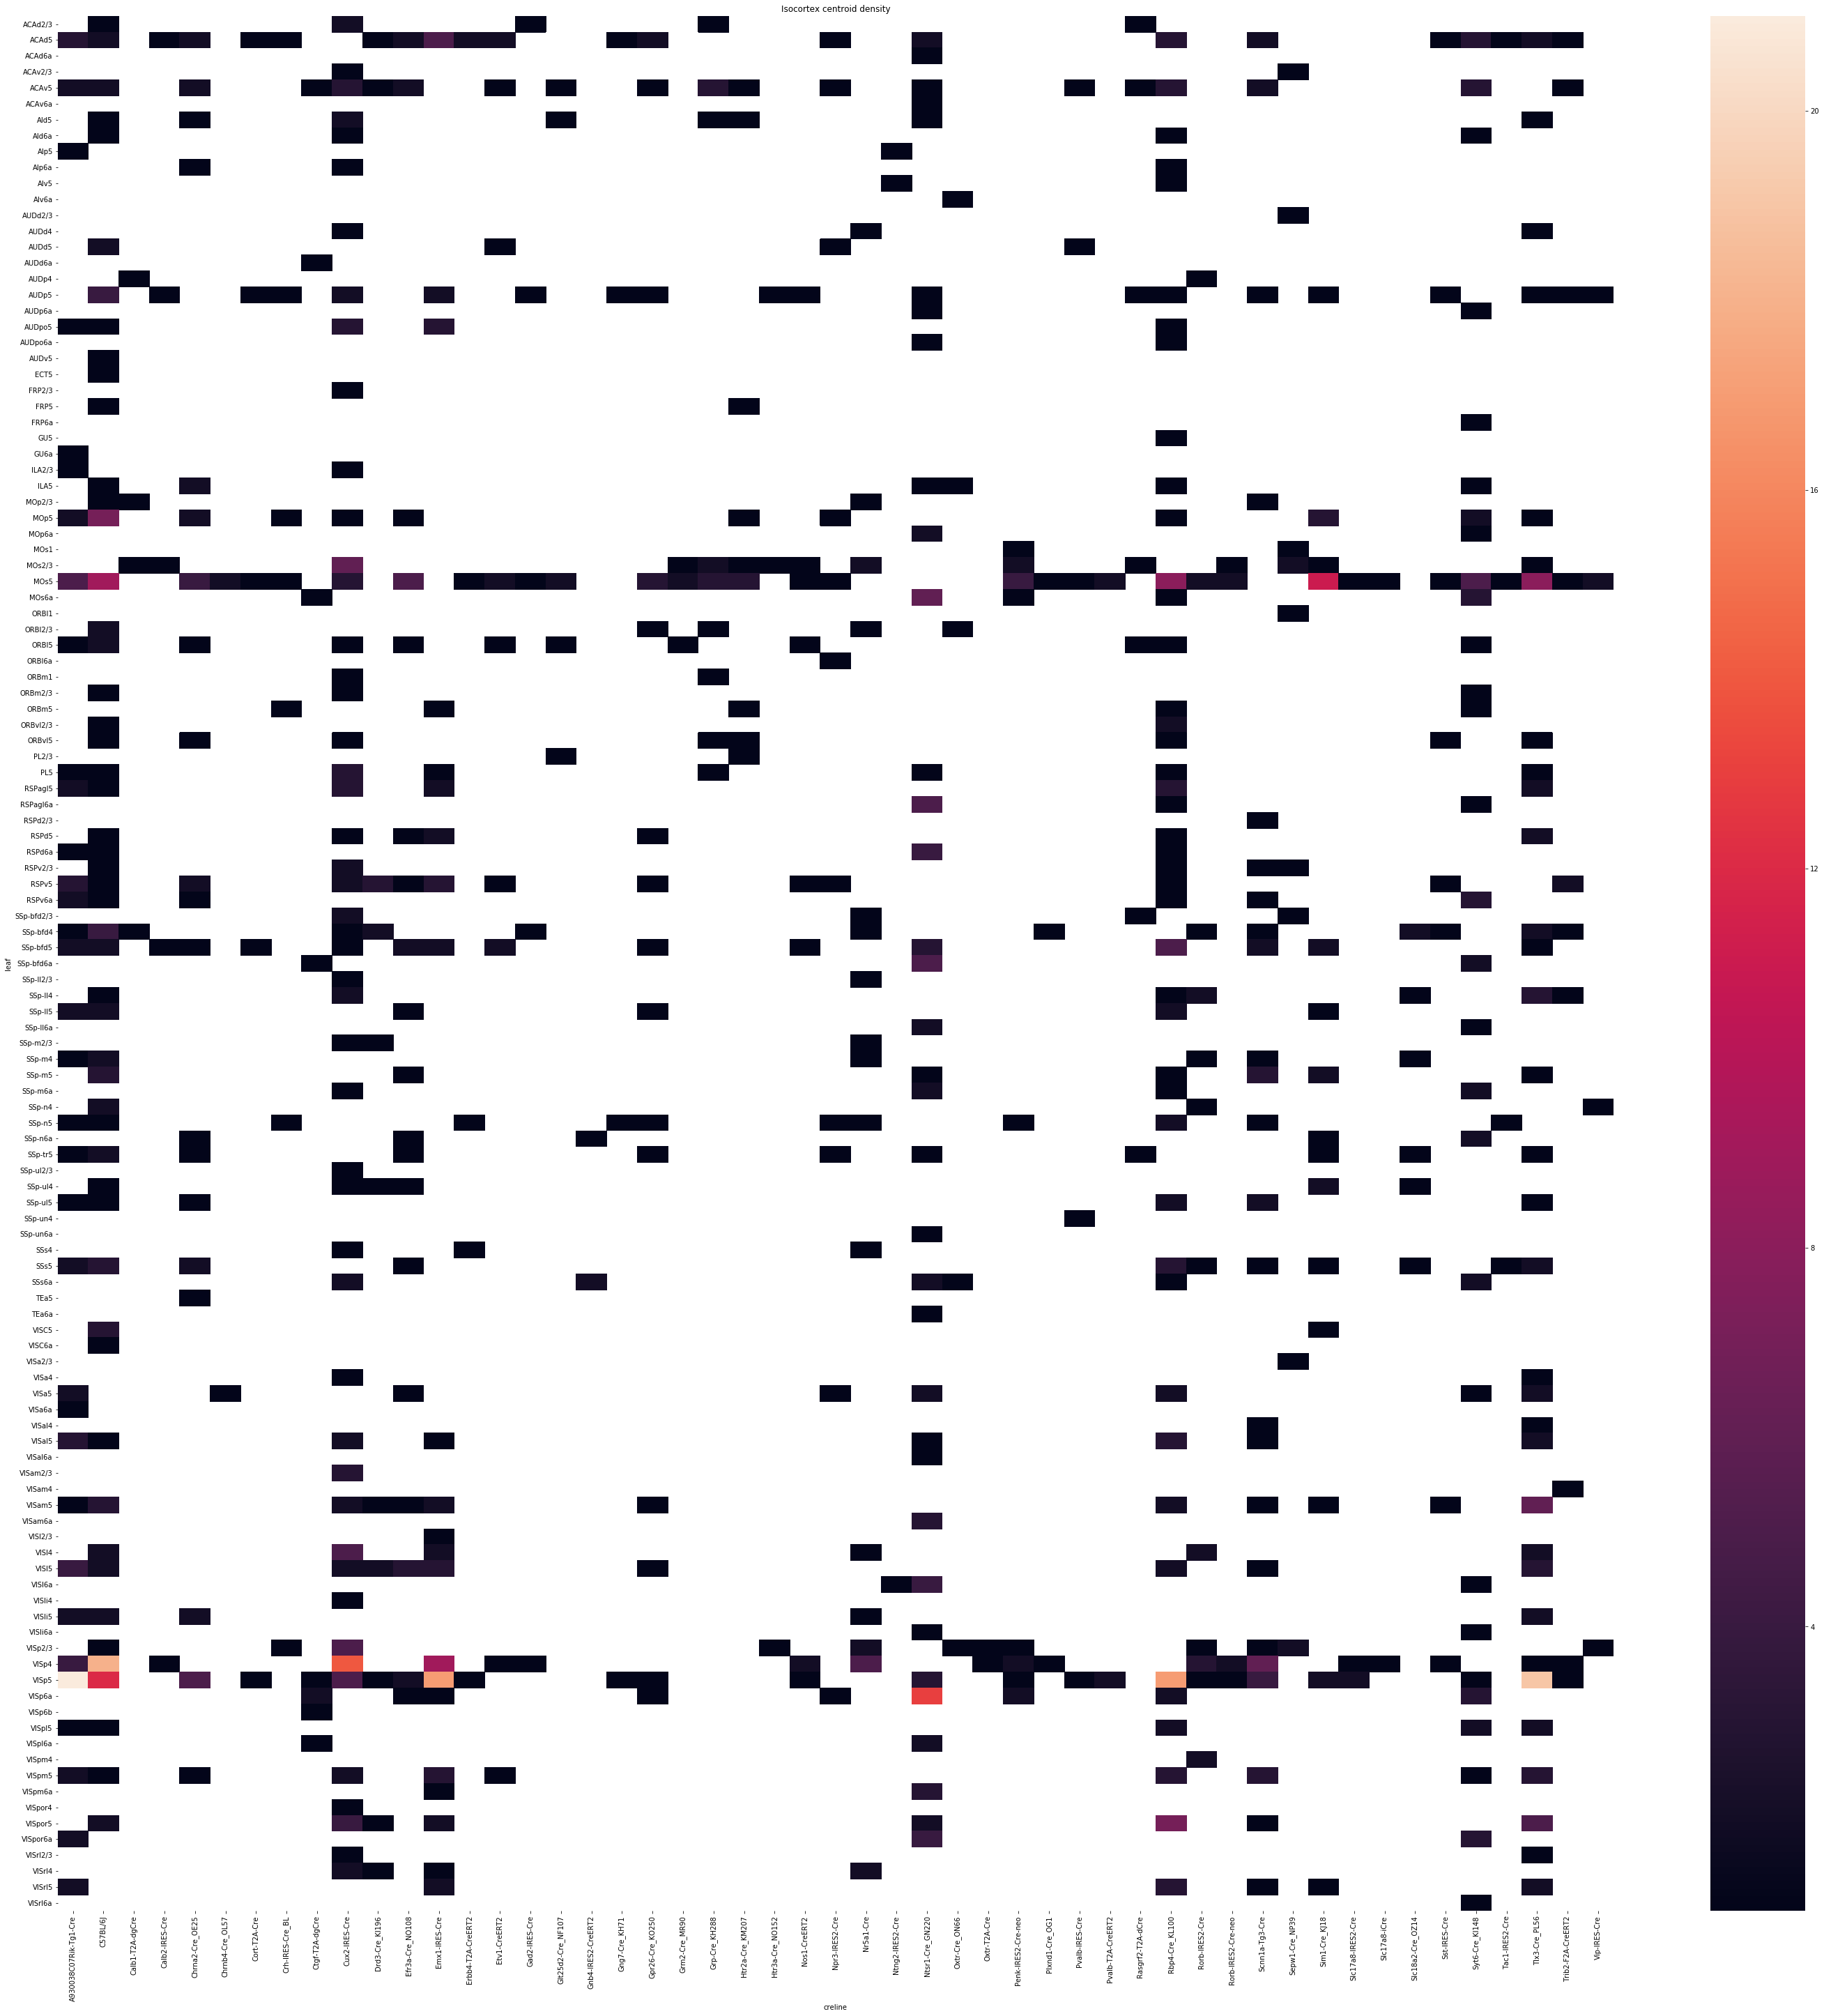

In [32]:
    ls = [ia_map[leafs[sid][i]] for i in range(len(leafs[sid]))]
    crs = creline[sid]
    df = pd.DataFrame(np.asarray([ls, crs, np.ones(len(ls))]).transpose())
    df.columns = np.asarray(['leaf', 'creline','present'])
    a = df.pivot_table(values='present',index='leaf',columns='creline',aggfunc=np.sum)

    fig, ax = plt.subplots(1,figsize = (50,50))
    sns.heatmap(a, ax = ax)
    plt.title(str(major_structures[m]) + ' centroid density')

In [33]:
# %matplotlib notebook
# #%matplotlib inline
# fig = plt.figure()
# ax = Axes3D(fig)

# # ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
# #            msvds[sid].projection_mask.coordinates[:,1], 
# #            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)

# nvox = connectivity_data[sid].projections.shape[1]
# proj_colors = np.zeros((nvox,4))
# proj_colors[:,0] = 1.0
# proj_colors[:, 3] = connectivity_data[sid].projections[ind] / connectivity_data[sid].projections[ind].max()

# ax.scatter(connectivity_data[sid].projection_mask.coordinates[:,0], 
#            connectivity_data[sid].projection_mask.coordinates[:,1], 
#            connectivity_data[sid].projection_mask.coordinates[:,2], s= .1, c= proj_colors)

# nvox = connectivity_data[sid].injections.shape[1]
# inj_colors = np.zeros((nvox,4))
# inj_colors[:,1] = 1.0
# inj_colors[:, 3] = connectivity_data[sid].injections[ind] / connectivity_data[sid].injections[ind].max()


# ax.scatter(connectivity_data[sid].injection_mask.coordinates[:,0], 
#            connectivity_data[sid].injection_mask.coordinates[:,1], 
#            connectivity_data[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

# ax.set_axis_off()

In [34]:
connectivity_data.structure_datas[315].experiment_datas[293472335].injection_signal_true.sum()

141.67735

In [35]:
connectivity_data.structure_datas[315].experiment_datas[293472335].injection_qmasked.sum()

141.67735

In [36]:
connectivity_data.structure_datas[315].experiment_datas[293472335].injection_vec.sum()

138.53488

In [25]:
138.53488/ 141.67735

0.9778195314918016

In [ ]:
connectivity_data.structure_datas[315].injections[303].sum()

In [27]:
ind = 303#40#303#111#40

In [28]:
m4 = Mask.from_cache(cache,structure_ids=[ai_map['VISp4']],hemisphere_id=2)

m5 = Mask.from_cache(cache,structure_ids=[ai_map['VISp5']],hemisphere_id=2)

m6a = Mask.from_cache(cache,structure_ids=[ai_map['VISp6a']],hemisphere_id=2)


<IPython.core.display.Javascript object>


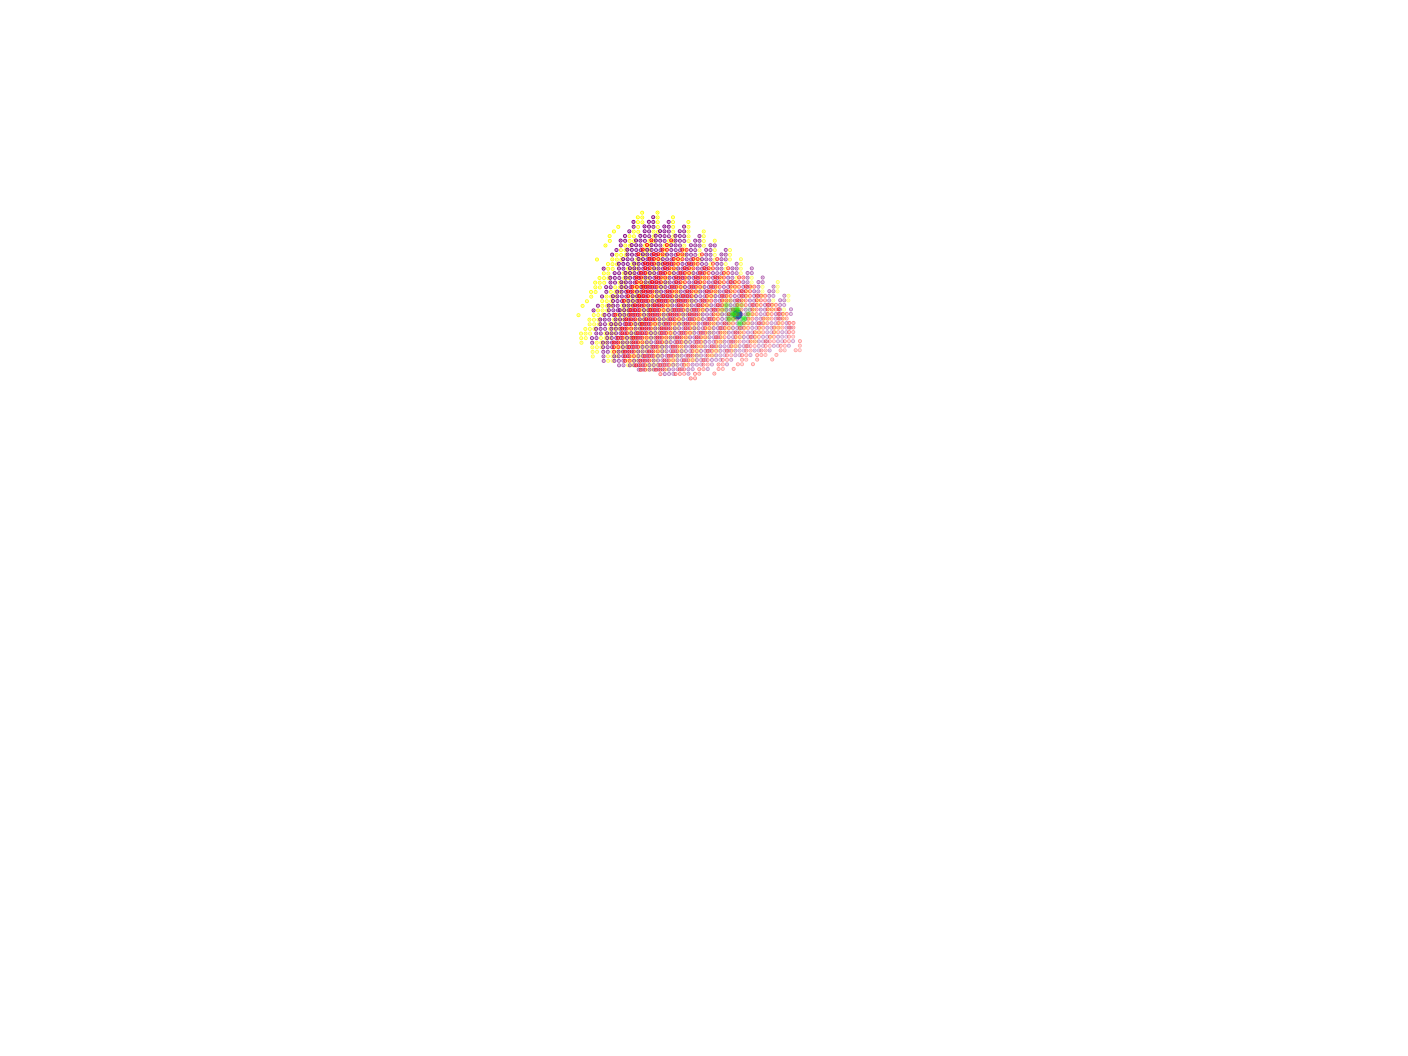

In [29]:
%matplotlib notebook
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

# ax.scatter(msvds[sid].projection_mask.coordinates[:,0], 
#            msvds[sid].projection_mask.coordinates[:,1], 
#            msvds[sid].projection_mask.coordinates[:,2], alpha = .01, s = .1)


nvox = connectivity_data.structure_datas[sid].injections.shape[1]
inj_colors = np.zeros((nvox,4))
inj_colors[:,1] = 1.0
inj_colors[:, 3] = connectivity_data.structure_datas[sid].injections[ind] / connectivity_data.structure_datas[sid].injections[ind].max()


ax.scatter(m4.coordinates[:,0], 
           m4.coordinates[:,1], 
           m4.coordinates[:,2], s= .1, c= 'yellow')

ax.scatter(m5.coordinates[:,0], 
           m5.coordinates[:,1], 
           m5.coordinates[:,2], s= .1, c= 'purple')

ax.scatter(m6a.coordinates[:,0], 
           m6a.coordinates[:,1], 
           m6a.coordinates[:,2], s= .1, c= 'red')

ax.scatter(connectivity_data.structure_datas[sid].centroids[ind][0],
          connectivity_data.structure_datas[sid].centroids[ind][1],
          connectivity_data.structure_datas[sid].centroids[ind][2], s = 5)

ax.scatter(connectivity_data.structure_datas[sid].injection_mask.coordinates[:,0], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,1], 
           connectivity_data.structure_datas[sid].injection_mask.coordinates[:,2], s= 1, c= inj_colors)

ax.set_axis_off()

In [46]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids[4:5]:
    print(sid)
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids[4:5]:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]
    
indices_creleaf = {}
indices_creleaf2ormore = {}
for sid in major_structure_ids[4:5]:
    indices_creleaf[sid] = get_indices(np.asarray(creleafs_merged[sid]))
    indices_creleaf2ormore[sid] = screen_index_matrices(indices_creleaf[sid], indices_creleaf[sid])

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

315


In [25]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def get_cre_similarity(proj, cres,eminors,colnames):

    ss = np.append(['cre','injsum'],colnames)
    ns = np.concatenate([np.empty(2, dtype = str), np.repeat('ipsi',291), np.repeat('contra',286)])
    colns = np.vstack([ns,ss]).transpose()
    clns = list(zip(*colns.transpose()))
    clnsmi = pd.MultiIndex.from_tuples(clns, names=['first', 'second'])
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),proj ]), columns= clnsmi)
    data_melted = pd.melt(data_merged, id_vars=[('','cre'),('','injsum')])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['first', 'second',('','cre'),('','injsum')])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = [('','cre'),('','injsum')], columns = ['first', 'second'])
    cs = np.asarray(list(means_cast.index))    
    return(means_cast,cs)

def get_cre_dist_cv(proj, means_cast, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        #get mean of all points sharing cre line and minor structure with this one (but not including)
        meani = means_cast.loc[tuple([cres[i], eminors[i]])]
#         ncr = len(np.where(cres == cres[i])[0])
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        #this was originally
        #print(meanloocvi.max(), 'max', ncr)

        #meanloocvi = meani
        #meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* msvd.reg_proj_vcount_norm_renorm[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        #rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            meanj = means_cast.loc[tuple([cres[j], eminors[j]])]
            #t= tuple([cres[i], cres[j]])
            #if np.isin(t, rkeys).all():
            if eminors[j] == eminors[i]:
                credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [33]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [34]:

def get_loss_surface(proj,centroids,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    projs = proj
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        #print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    dc = np.asarray([ds2,cs2,ls2]).transpose()
    qqq = NadarayaWatson(kernel='rbf',  gamma  = 2000000)
    #qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    return(qqq)

def get_smoothed_losses(proj,centroids, qqq, cre_dist):
    ds = pairwise_distances(centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(proj)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[di, ci]]))#qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [35]:

def get_loss_surface_control(proj,centroids,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    projs = proj
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        #print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    
    dc = np.asarray([ds2,cs2,ls2]).transpose()
    dc[:,1] = np.zeros(dc[:,1].shape[0])
    qqq = NadarayaWatson(kernel='rbf',  gamma  = 200000)
    #qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    
    return(qqq)


In [36]:
def get_smoothed_losses_control(proj,centroids, qqq, cre_dist):
    ds = pairwise_distances(centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(proj)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[di, 0.]]))
    return(smoothedlosses)

In [37]:
from mcmodels.regressors import NadarayaWatson
import math

In [38]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls = {}
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    #msvd = msvds[sid]
    cres = creline[sid]
    eminors = leafs[sid]
    means_cast, cs = get_cre_similarity(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, cres,eminors, colnames)
    cre_dist2 = get_cre_dist_cv(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, means_cast, eminors,cres)
    qqq = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids, cre_dist2,frac_learn[m])


315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [40]:
    sls[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,qqq, cre_dist2)

Text(0.5, 0, 'Projection distance predicted')

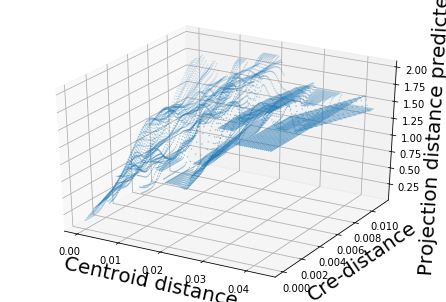

In [46]:

cs = cre_dist2
fraction = .1
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = connectivity_data.structure_datas[sid].centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = connectivity_data.structure_datas[sid].centroids
projs = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    #print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)


qqq = NadarayaWatson(kernel='rbf',  gamma  = 2000000)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

(0.0, 0.01)

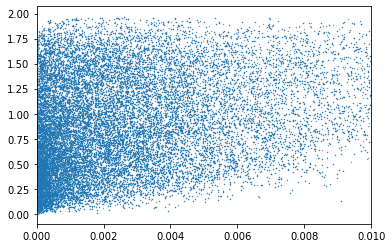

In [54]:
plt.scatter(ds2,ls2, s =.1
           )
plt.xlim(0.,0.01)

In [60]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls_control = {}
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    #msvd = msvds[sid]
#    cres = creline[sid]
#    eminors = leafs[sid]
#    means_cast, cs = get_cre_similarity(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, cres,eminors, colnames)
#    cre_dist2 = get_cre_dist_cv(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, means_cast, eminors,cres)
    qqq_control = get_loss_surface_control(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids, cre_dist2,frac_learn[m])
    sls_control[sid] = get_smoothed_losses_control(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,qqq_control, cre_dist2)

315


In [29]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls_control[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


NameError: name 'sls_control' is not defined

In [58]:
meanloss_nw_leaf_leaf2

NameError: name 'meanloss_nw_leaf_leaf2' is not defined

In [31]:
#qqq = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids, cre_dist2,frac_learn[m])

sls[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,qqq, cre_dist2)

NameError: name 'qqq' is not defined

In [56]:
sls[sid]

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.49283205,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.12250681, ...,        nan,        nan,
        1.4686094 ],
       ...,
       [       nan,        nan,        nan, ..., 0.12115562,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.49325563,
               nan],
       [       nan,        nan, 1.46860937, ...,        nan,        nan,
        0.12479631]])

In [47]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


(119, 5, 1128, 577)
0


In [48]:
best_gamma_leaf_leaf2

array([[0]])

In [49]:
meanloss_nw_leaf_leaf2

array([0.29162051])

In [71]:
meanloss_nw_leaf_leaf2

array([0.24499397])

In [58]:
meanloss_nw_leaf_leaf2

array([0.26311958])

In [44]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .01
sls_injnorm = {}
for m in range(4,5):
    sid = major_structure_ids[m]#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    #msvd = msvds[sid]
    cres = creline[sid]
    eminors = leafs[sid]
    means_cast_injnorm, cs = get_cre_similarity(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, cres,eminors, colnames)
    cre_dist2_injnorm = get_cre_dist_cv(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, means_cast_injnorm, eminors,cres)
    qqq_injnorm = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, connectivity_data.structure_datas[sid].centroids, cre_dist2_injnorm,frac_learn[m])
    sls_injnorm[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, connectivity_data.structure_datas[sid].centroids,qqq_injnorm, cre_dist2_injnorm)

315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [52]:
sls_injnorm[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, connectivity_data.structure_datas[sid].centroids,qqq_injnorm, cre_dist2_injnorm)

In [53]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm, 
                                                                                       sls_injnorm[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_injnorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in true_divide


(119, 5, 1128, 577)
0


In [54]:
meanloss_nw_leaf_leaf2

array([0.69659355])

In [63]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       connectivity_data.structure_datas[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

(119, 5, 1128, 577)
0


In [64]:
meanloss_nw_leaf_leaf2

array([0.41030983])

In [65]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       connectivity_data.structure_datas[sid].centroids, 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/e

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_0

(620, 5, 1128, 577)
0


In [66]:
meanloss_nw_leaf_leaf2

array([0.24386396])

In [67]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


(620, 5, 1128, 577)
0


In [68]:
meanloss_nw_leaf_leaf2

array([0.30312555])

Text(0.5, 0, 'Projection distance predicted')

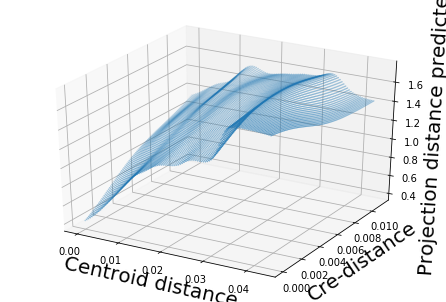

In [86]:

cs = cre_dist2
fraction = .1
#ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
nsamp = connectivity_data.structure_datas[sid].centroids.shape[0]
#need source and target color
source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
ngp = goodpairs.shape[0]
centroids = connectivity_data.structure_datas[sid].centroids
projs = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
ds2 = np.zeros(ngp)
ls2 = np.zeros(ngp)
for i in range(ngp):
    #print(i)
    ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
    ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2

cs2 = cs[np.where(~np.isnan(cs))]    
#ds2 = ds[np.where(~np.isnan(cs))]
#
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2 / dsnorm
cs2 = cs2 / csnorm
#ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()
#ids = np.linspace(0,35, 36, dtype = int), 36)


qqq = NadarayaWatson(kernel='rbf',  gamma  = 100000)
randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [89]:
#qqq = get_loss_surface(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids, cre_dist2,frac_learn[m])
sls[sid] = get_smoothed_losses(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, connectivity_data.structure_datas[sid].centroids,qqq, cre_dist2)

In [93]:
sls[sid] - np.nanmin(sls[sid])

0.4419690960604784

In [64]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


(620, 5, 1128, 577)
0


In [66]:
best_gamma_leaf_leaf2

array([[0]])

In [65]:
meanloss_nw_leaf_leaf2

array([0.2975527])

In [ ]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_creleaf2ormore[sid], 
                                                                                       indices_creleaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)
losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)


In [67]:

def get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] * gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[i,:] / np.nansum(weights[i,:][otherindices])
            #print(np.nansum(weights[:,i][otherindices]))
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            weights_i[np.isnan(weights_i)] = 0.
            if np.sum(weights_i) > 0.:
                #print('here')
                pred = np.dot(weights_i, projections[model_index_val])
            else:
                print('here')
                am = np.argmin(dists[model_index_val[otherindices]][:, eval_index_val[i]])
                pred = projections[model_index_val[otherindices[am]]]
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

def get_nwloocv_predictions_multimodel_merge_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists_near(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists_near(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

In [147]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists_near(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid]**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [125]:
best_gamma_leaf_leaf2

array([[4]])

In [121]:
losses_leaf_leaf2[315]

array([[0.28613403, 0.82088745, 0.27448013, ..., 0.39424903, 0.63321853,
        0.63586991],
       [0.2644913 , 0.76294732, 0.27278815, ..., 0.34897366, 0.59322368,
        0.58727793],
       [0.2402108 , 0.69836852, 0.27090827, ..., 0.29647612, 0.54667619,
        0.54489311],
       [0.20068444, 0.5959025 , 0.26779826, ..., 0.2097525 , 0.46712455,
        0.49594143],
       [0.10602984, 0.39051615, 0.26039908, ..., 0.05980718, 0.23558013,
        0.4577818 ]])

In [111]:
losses_leaf_leaf2[315]

array([[0.28910395, 0.82859526, 0.27463551, ..., 0.39811623, 0.63877579,
        0.64360272],
       [0.27839414, 0.7984572 , 0.27349649, ..., 0.36725731, 0.61993771,
        0.61726633],
       [0.26560045, 0.76110207, 0.27217358, ..., 0.32975681, 0.59691583,
        0.58874884],
       [0.24204573, 0.68919644, 0.26983035, ..., 0.26067174, 0.55300388,
        0.54415876],
       [0.13717545, 0.40817478, 0.26096748, ..., 0.06457765, 0.3269819 ,
        0.44866571]])

In [119]:
np.where(np.isnan(losses_leaf_leaf2[315]))

(array([], dtype=int64), array([], dtype=int64))

In [102]:
(sls[sid] - np.nanmin(sls[sid]))

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.42884743,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.0231736 , ...,        nan,        nan,
        0.99550204],
       ...,
       [       nan,        nan,        nan, ..., 0.00688161,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.4284022 ,
               nan],
       [       nan,        nan, 0.99368569, ...,        nan,        nan,
        0.03305078]])

In [144]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.29017249]))

In [130]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.22832521]))

In [146]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.22832521]))

In [148]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.2358546]))

In [132]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.38285447]))

In [104]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.27430117]))

In [91]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.27430117]))

In [85]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.26118227]))

In [70]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.25034176]))

In [80]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(119, 5, 1128, 577)
0


In [81]:
meanloss_nw_leaf_leaf2

array([0.25034176])

In [75]:
cre_dist2

(1128, 1128)

In [77]:
pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2

In [78]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids[4:5]:
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm, 
                                                                                       cre_dist2 + pds, 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids[4:5]:
    reg_proj_vcount_norm_renorms[sid ] = connectivity_data.structure_datas[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2

eval_indices_creleaf2ormore = get_eval_indices(indices_creleaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_creleaf2ormore, true_ind = eval_indices_creleaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:278: RuntimeWarning: overflow encountered in true_divide


(119, 5, 1128, 577)
0


In [79]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[4]]), array([0.4035137]))

In [74]:
best_gamma_leaf_leaf2, meanloss_nw_leaf_leaf2

(array([[0]]), array([0.25034176]))

In [73]:
np.where(np.isnan(losses_leaf_leaf2[315])) #theres nans in losses_leaf_leaf2[315] but not in _dists

(array([], dtype=int64), array([], dtype=int64))

In [ ]:





# creline = get_cre_status(data_info, connectivity_data)
# with open('data/info/leafs.pickle', 'rb') as handle:
#     leafs = pickle.load(handle)
    
# minor_structures = get_minorstructure_dictionary(msvds, data_info)
# ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
# key = list(msvd.experiments.keys())[0]

# #Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
# contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
# #get average intensities of projection structures given ipsi and contra keys
# source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument

# #need to compare with cre-specific model

# NW_losses_leaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
# NW_losses_creleaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nw_loocv_leaf_leaf2,pred_ind = indices_creleaf_2ormore, true_ind = indices_creleaf_2ormore,keys = keys)
# NWcre_losses_creleaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nwcre_loocv_leaf_leaf2,pred_ind = indices_creleaf_2ormore, true_ind = indices_creleaf_2ormore,keys = keys)
# NW_cre_losses_creleaf2ormore = get_loss(reg_proj_vcount_norm_renorms, nw_cre_loocv_leaf_leaf2,pred_ind = indices_creleaf_2ormore, true_ind = indices_creleaf_2ormore,keys = keys)

# #get best hyps... plot loss by cre... plot loss by region

# #make connectivities

# #= get_crossvalidation_scores(connectivity_data, indices_creleaf_2ormore, model = 'NW_cre')

In [ ]:
# def get_centroid(experiment):
#     """Returns experiment centroid"""
#     return experiment.centroid

# def get_injection(experiment, normalized_injection):
#     # print('ts',experiment.normalized_injection)
#     """Returns experiment injection masked & flattened"""
#     injection = experiment.get_injection(normalized_injection)
#     return experiment.injection_mask.mask_volume(injection)

# def get_projection(experiment, normalized_projection):
#     """Returns experiment projection masked & flattened"""
#     projection = experiment.get_projection(normalized_projection)
#     return experiment.projection_mask.mask_volume(projection)

# def yield_experiments(experiments):
#     ev = experiments.values()
#     keys = np.asarray(list(experiments.keys()))
#     for i in range(len(keys)):
#         yield (experiments[keys[i]])

# def get_matrices(experiments):
#     get_data = lambda x: (get_centroid(x),
#                           get_injection(x,True),
#                           get_projection(x, True))
#     arrays = map(get_data, yield_experiments(experiments))
#     centroids, injections, projections = map(np.array, zip(*arrays))
#     return(centroids, injections, projections) 

# experiment.projection_mask.mask_volume(projection)

In [ ]:



# def get_matrices(experiments):
#     get_data = lambda x: (get_centroid(x),
#                           get_injection(x,True),
#                           get_projection(x, True))
#     arrays = map(get_data, yield_experiments(experiments))
#     centroids, injections, projections = map(np.array, zip(*arrays))
#     return(centroids, injections, projections)

In [ ]:
#     #msvd2 = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)

#     voxel_data = ModelData(cache, sid)
#     experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
#     experiment_ids = np.asarray(list(experiment_ids))
#     experiments = {}
#     # print('h')

#     # experiment
#     injection_mask = Mask.from_cache(
#         cache,
#         structure_ids=[sid],
#         hemisphere_id=2)
#     projection_mask = Mask.from_cache(
#         cache,
#         structure_ids=default_structure_ids,
#         hemisphere_id=3)

#     #first we get the experiment
#     #experiment.from_cache populates injection and projection density
#     for eid in experiment_ids[:1]:
#         # print(eid)
#         experiments[eid] = get_experiment(cache, eid, sid,default_structure_ids)
#         experiments[eid].projection_mask = projection_mask
#         experiments[eid].injection_mask = injection_mask

#     #then we get the matrices... uses experiment.get_injection and .get_projection
#     VDs = VoxelDataset()
#     VDs.sid = sid
#     VDs.projection_mask = projection_mask
#     VDs.injection_mask = injection_mask
#     VDs.experiments = experiments
#     VDs.centroids, VDs.injections, VDs.projections = get_matrices(experiments)

In [19]:
# """
# Module containing Experiment object and supporting functions.
# """
# # Authors: Joseph Knox <josephk@alleninstitute.org>
# # License: Allen Institute Software License

# from __future__ import division
# from functools import partial

# import numpy as np

# #from .utils import compute_centroid, get_injection_hemisphere_id

# #from .model_data import ModelData #.model_data import ModelData
# #from .masks import Mask
# #from .utils import compute_centroid, get_injection_hemisphere_id
# #from .utils import get_matrices


# class VoxelDataset:
#     """

#     Parameters
#     ----------
#     sid: structure id

#     Notes
#     _____
#     This class holds a collection of experiments in a particular structure
#     """
#     def __init__(self):#, sid):
#         pass
#         #self.sid = sid

# def get_centroid(experiment):
#     """Returns experiment centroid"""
#     return experiment.centroid

# def get_injection(experiment, normalized_injection):
#     # print('ts',experiment.normalized_injection)
#     """Returns experiment injection masked & flattened"""
#     injection = experiment.get_injection(normalized_injection)
#     return experiment.injection_mask.mask_volume(injection)

# def get_projection(experiment, normalized_projection):
#     """Returns experiment projection masked & flattened"""
#     projection = experiment.get_projection(normalized_projection)
#     return experiment.projection_mask.mask_volume(projection)

# def yield_experiments(experiments):
#     ev = experiments.values()
#     keys = np.asarray(list(experiments.keys()))
#     for i in range(len(keys)):
#         yield (experiments[keys[i]])

# def get_matrices(experiments):
#     get_data = lambda x: (get_centroid(x),
#                           get_injection(x,True),
#                           get_projection(x, True))
#     arrays = map(get_data, yield_experiments(experiments))
#     centroids, injections, projections = map(np.array, zip(*arrays))
#     return(centroids, injections, projections)


# def get_experiment(cache, eid,sid,default_structure_ids):
#     experiment = Experiment.from_cache(cache, eid)
#     hemisphere_id = experiment.injection_hemisphere_id
#     if hemisphere_id == 1:
#         experiment = experiment.flip()
# #     if (experiment.injection_hemisphere_id == 3 or hemisphere_id == experiment.injection_hemisphere_id):
# #        experiment = experiment
# #     elif experiment.flip_experiments:
# #        experiment = experiment.flip()

#     experiment.injection_structure_ids = [sid]
#     experiment.major_structure = sid
#     experiment.projection_structure_ids = default_structure_ids
#     experiment.projection_hemisphere_id = 3
#     experiment.normalized_injection = True
#     experiment.normalized_projection = True
#     return (experiment)

# def get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre):
#     '''

#     :param cache:
#     :param sid:
#     :param experiments_exclude:
#     :param default_structure_ids:
#     :param cre:
#     :return:
#     '''
#     voxel_data = ModelData(cache, sid)
#     experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
#     experiment_ids = np.asarray(list(experiment_ids))
#     experiments = {}
#     # print('h')

#     # experiment
#     injection_mask = Mask.from_cache(
#         cache,
#         structure_ids=[sid],
#         hemisphere_id=2)
#     projection_mask = Mask.from_cache(
#         cache,
#         structure_ids=default_structure_ids,
#         hemisphere_id=3)

#     #first we get the experiment
#     #this calls from_cache
#     #experiment.from_cache populates injection and projection density as follows
#     #the injection fraction (the fraction of injection in that voxel) is applied
#     #this appears to be done twice for some reason
#     #the data quality mask is applied
#     #
    
# #                 data_volumes = _pull_grid_data(cache, experiment_id)
# #         except AttributeError:
# #             raise ValueError('cache must be a MouseConnectivityCache or '
# #                              'VoxelModelCache object, not %s' % type(cache))

# #         # compute 'true' injection density (inplace)
# #         _compute_true_injection_density(data_volumes["injection_density"],
# #                                         data_volumes["injection_fraction"],
# #                                         inplace=True)

# #         # mask data in place
# #         mask_func = partial(_mask_data_volume,
# #                             data_mask=data_volumes["data_mask"],
# #                             tolerance=data_mask_tolerance)

# #         injection_density = mask_func(data_volumes["injection_density"])
# #         projection_density = mask_func(data_volumes["projection_density"])

# #     if inplace:
# #         np.multiply(injection_density, injection_fraction, injection_density)
# #         return injection_density

# #     return np.multiply(injection_density, injection_fraction)

#     for eid in experiment_ids:
#         # print(eid)
#         experiments[eid] = get_experiment(cache, eid, sid,default_structure_ids)
#         experiments[eid].projection_mask = projection_mask
#         experiments[eid].injection_mask = injection_mask

#     #then we get the matrices... uses experiment.get_injection and .get_projection
#     #self.injection_density / self.injection_volume
#     VDs = VoxelDataset()
#     VDs.sid = sid
#     VDs.projection_mask = projection_mask
#     VDs.injection_mask = injection_mask
#     VDs.experiments = experiments
#     VDs.centroids, VDs.injections, VDs.projections = get_matrices(experiments)
#     return (VDs)

# def _pull_grid_data(cache, experiment_id):
#     """Pulls data volumes using VoxelModelCache object.

#     Parameters
#     ----------
#     cache : VoxelModelCache or MouseConnectivityCache instance.
#         Object used to pull grid data.

#     experiment_id : int
#         Experiment id of the experiment from which to pull grid data.

#     Returns
#     -------
#     dict
#         Container of relevant data volumes.
#         See allensdk.core.mouse_connectivity_cache for description of volumes.

#     Notes
#     -----
#     voxel_model_cache.get_<data_volume> returns a tuple (data_volume, meta_data).
#     We only care about the data volume.

#     """
#     return {
#         "data_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_density" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_density" : cache.get_projection_density(experiment_id)[0]
#     }


# def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
#     """Masks a given data volume in place.

#     Parameters
#     ----------
#     data_volume : array, shape (x_ccf, y_ccf, z_ccf)
#         Data volume to be masked.

#     data_mask : array, shape (x_ccf, y_ccf, z_ccf)
#         data_mask for given experiment (values in [0,1])
#         See allensdk.core.mouse_connectivity_cache for more info.

#     tolerance : float, optional (default=0.0)
#         tolerance with which to define bad voxels in data_mask.


#     Returns
#     -------
#     data_volume
#         data_volume parameter masked in place.

#     """
#     if data_volume.shape != data_mask.shape:
#         raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
#                          "shape!" % (data_volume.shape, data_mask.shape))

#     # mask data volume
#     data_volume[data_mask < tolerance] = 0.0

#     return data_volume


# def _compute_true_injection_density(injection_density, injection_fraction, inplace=False):
#     """Computes 'true' injection_density.

#     Takes into consideration injection fracion (proportion of pixels in the
#     annotated injection site).

#     Parameters
#     ----------
#     injection_density : array, shape (x_ccf, y_ccf, z_ccf)
#         injection_density data volume.

#     injection_fraction : array, shape (x_ccf, y_ccf, z_ccf)
#         injection_fraction data volume.

#     inplace : boolean
#         If True, overwrites injection_density parameter, else returns new array.

#     Returns
#     -------
#     array, shape (x_ccf, y_ccf, z_ccf)
#         'true' injection density : injection_density * injection_fraction
#     """
#     if injection_density.shape != injection_fraction.shape:
#         raise ValueError("injection_density (%s) and injection_fraction "
#                          "(%s) must be the same shape!"
#                          % (injection_density.shape, injection_fraction.shape))

#     if inplace:
#         np.multiply(injection_density, injection_fraction, injection_density)
#         return injection_density

#     return np.multiply(injection_density, injection_fraction)


# class Experiment(object):
#     """Class containing the data from an anterograde injection

#     Experiment conveniently compiles the relevant information from a given
#     anterograde viral tracing experiment data.

#     Parameters
#     ----------
#     voxel_model_cache : VoxelModelCache object
#         This supplies the interface for pulling experimental data.

#     experiment_id : int
#         AllenSDK id assigned to given experiment

#     Examples
#     --------
#     >>> from mcmodels.core import Experiment, VoxelModelCache
#     >>> cache = VoxelModelCache()
#     >>> eid = 100141273
#     >>> exp = Experiment(voxel_model_cache, eid)
#     >>> exp.injection_density.shape
#     (132,80,114)
#     """

#     DEFAULT_DATA_MASK_TOLERANCE = 0.5

#     @classmethod
#     def from_cache(cls, cache, experiment_id, data_mask_tolerance=None):
#         """Alternative constructor allowing for pulling grid data.

#         Parameters
#         ----------
#         cache : VoxelModelCache or MouseConnectivityCache instance.
#             Object used to pull grid data.

#         experiment_id : int
#             Experiment id of the experiment from which to pull grid data.

#         data_mask_tolerance : float, optional (default = None)
#             Tolerance with which to mask 'bad' data. data_mask array has values
#             on the interval [0,1], where a nonzero element indicates a 'bad'
#             voxel. If None is passed, the parameter defaults to
#             DEFAULT_DATA_MASK_TOLERANCE (0.5).
#         """
#         if data_mask_tolerance is None:
#             data_mask_tolerance = cls.DEFAULT_DATA_MASK_TOLERANCE

#         try:
#             # pull data
#             data_volumes = _pull_grid_data(cache, experiment_id)
#         except AttributeError:
#             raise ValueError('cache must be a MouseConnectivityCache or '
#                              'VoxelModelCache object, not %s' % type(cache))

#         # compute 'true' injection density (inplace)
#         _compute_true_injection_density(data_volumes["injection_density"],
#                                         data_volumes["injection_fraction"],
#                                         inplace=True)

#         # mask data in place
#         mask_func = partial(_mask_data_volume,
#                             data_mask=data_volumes["data_mask"],
#                             tolerance=data_mask_tolerance)

#         injection_density = mask_func(data_volumes["injection_density"])
#         projection_density = mask_func(data_volumes["projection_density"])

#         return cls(injection_density, projection_density)


#     def __init__(self, injection_density=None, projection_density=None):
#         # assume numpy array
#         if injection_density.shape != projection_density.shape:
#             raise ValueError("injection_density (%s) and projection_density "
#                              "(%s) must be the same shape!"
#                              % (injection_density.shape, projection_density.shape))

#         self.injection_density = injection_density
#         self.projection_density = projection_density

#     def __repr__(self):
#         return '{0}(volume_shape={1})'.format(
#             self.__class__.__name__, self.injection_density.shape)

#     @property
#     def injection_hemisphere_id(self):
#         """Returns injection hemisphere"""
#         return get_injection_hemisphere_id(self.injection_density, majority=True)

#     @property
#     def bilateral_injection(self):
#         """Returns injection hemisphere"""
#         return get_injection_hemisphere_id(self.injection_density) == 3

#     @property
#     def injection_volume(self):
#         """Returns total injection volume = sum(injection_density)"""
#         return self.injection_density.sum()

#     @property
#     def projection_volume(self):
#         """Returns total projection volume = sum(projection_density)"""
#         return self.projection_density.sum()

#     @property
#     def centroid(self):
#         """Returns centroid of the injection density."""
#         return compute_centroid(self.injection_density)

#     @property
#     def normalized_injection_density(self):
#         """Returns injection density normalized to have unit sum."""
#         return self.injection_density / self.injection_volume

#     @property
#     def normalized_projection_density(self):
#         """Returns projection_density normalized by the total injection_density"""
#         return self.projection_density / self.injection_volume

#     def get_injection(self, normalized=False):
#         if normalized:
#             return self.normalized_injection_density
#         return self.injection_density

#     def get_projection(self, normalized=False):
#         if normalized:
#             return self.normalized_projection_density
#         return self.projection_density

#     def flip(self):
#         """Reflects experiment along midline.

#         Returns
#         -------
#         self - flipped experiment
#         """
#         self.injection_density = self.injection_density[..., ::-1]
#         self.projection_density = self.projection_density[..., ::-1]

#         return self


In [20]:
# """
# Module containing Experiment object and supporting functions.
# """
# # Authors: Joseph Knox <josephk@alleninstitute.org>
# # License: Allen Institute Software License

# from __future__ import division
# from functools import partial

# import numpy as np

# #from .utils import compute_centroid, get_injection_hemisphere_id

# #from .model_data import ModelData #.model_data import ModelData
# #from .masks import Mask
# #from .utils import compute_centroid, get_injection_hemisphere_id
# #from .utils import get_matrices


# class VoxelDataset:
#     """

#     Parameters
#     ----------
#     sid: structure id

#     Notes
#     _____
#     This class holds a collection of experiments in a particular structure
#     """
#     def __init__(self):#, sid):
#         pass
#         #self.sid = sid

# def get_centroid(experiment):
#     """Returns experiment centroid"""
#     return experiment.centroid

# def get_injection(experiment, normalized_injection):
#     # print('ts',experiment.normalized_injection)
#     """Returns experiment injection masked & flattened"""
#     injection = experiment.get_injection(normalized_injection)
#     return experiment.injection_mask.mask_volume(injection)

# def get_projection(experiment, normalized_projection):
#     """Returns experiment projection masked & flattened"""
#     projection = experiment.get_projection(normalized_projection)
#     return experiment.projection_mask.mask_volume(projection)

# def yield_experiments(experiments):
#     ev = experiments.values()
#     keys = np.asarray(list(experiments.keys()))
#     for i in range(len(keys)):
#         yield (experiments[keys[i]])

# def get_matrices(experiments):
#     get_data = lambda x: (get_centroid(x),
#                           get_injection(x,True),
#                           get_projection(x, True))
#     arrays = map(get_data, yield_experiments(experiments))
#     centroids, injections, projections = map(np.array, zip(*arrays))
#     return(centroids, injections, projections)


# def get_experiment(cache, eid,sid,default_structure_ids):
#     experiment = Experiment.from_cache(cache, eid)
#     hemisphere_id = experiment.injection_hemisphere_id
#     if hemisphere_id == 1:
#         experiment = experiment.flip()
# #     if (experiment.injection_hemisphere_id == 3 or hemisphere_id == experiment.injection_hemisphere_id):
# #        experiment = experiment
# #     elif experiment.flip_experiments:
# #        experiment = experiment.flip()

#     experiment.injection_structure_ids = [sid]
#     experiment.major_structure = sid
#     experiment.projection_structure_ids = default_structure_ids
#     experiment.projection_hemisphere_id = 3
#     experiment.normalized_injection = True
#     experiment.normalized_projection = True
#     return (experiment)

# def get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre):
#     '''

#     :param cache:
#     :param sid:
#     :param experiments_exclude:
#     :param default_structure_ids:
#     :param cre:
#     :return:
#     '''
#     voxel_data = ModelData(cache, sid)
#     experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
#     experiment_ids = np.asarray(list(experiment_ids))
#     experiments = {}
#     # print('h')

#     # experiment
#     injection_mask = Mask.from_cache(
#         cache,
#         structure_ids=[sid],
#         hemisphere_id=2)
#     projection_mask = Mask.from_cache(
#         cache,
#         structure_ids=default_structure_ids,
#         hemisphere_id=3)

#     #first we get the experiment
#     #this calls from_cache
#     #experiment.from_cache populates injection and projection density as follows
#     #the injection fraction (the fraction of injection in that voxel) is applied
#     #this appears to be done twice for some reason
#     #the data quality mask is applied
#     #
    
# #                 data_volumes = _pull_grid_data(cache, experiment_id)
# #         except AttributeError:
# #             raise ValueError('cache must be a MouseConnectivityCache or '
# #                              'VoxelModelCache object, not %s' % type(cache))

# #         # compute 'true' injection density (inplace)
# #         _compute_true_injection_density(data_volumes["injection_density"],
# #                                         data_volumes["injection_fraction"],
# #                                         inplace=True)

# #         # mask data in place
# #         mask_func = partial(_mask_data_volume,
# #                             data_mask=data_volumes["data_mask"],
# #                             tolerance=data_mask_tolerance)

# #         injection_density = mask_func(data_volumes["injection_density"])
# #         projection_density = mask_func(data_volumes["projection_density"])

# #     if inplace:
# #         np.multiply(injection_density, injection_fraction, injection_density)
# #         return injection_density

# #     return np.multiply(injection_density, injection_fraction)

#     for eid in experiment_ids:
#         # print(eid)
#         experiments[eid] = get_experiment(cache, eid, sid,default_structure_ids)
#         experiments[eid].projection_mask = projection_mask
#         experiments[eid].injection_mask = injection_mask

#     #then we get the matrices... uses experiment.get_injection and .get_projection
#     #self.injection_density / self.injection_volume
#     VDs = VoxelDataset()
#     VDs.sid = sid
#     VDs.projection_mask = projection_mask
#     VDs.injection_mask = injection_mask
#     VDs.experiments = experiments
#     VDs.centroids, VDs.injections, VDs.projections = get_matrices(experiments)
#     return (VDs)

# def _pull_grid_data(cache, experiment_id):
#     """Pulls data volumes using VoxelModelCache object.

#     Parameters
#     ----------
#     cache : VoxelModelCache or MouseConnectivityCache instance.
#         Object used to pull grid data.

#     experiment_id : int
#         Experiment id of the experiment from which to pull grid data.

#     Returns
#     -------
#     dict
#         Container of relevant data volumes.
#         See allensdk.core.mouse_connectivity_cache for description of volumes.

#     Notes
#     -----
#     voxel_model_cache.get_<data_volume> returns a tuple (data_volume, meta_data).
#     We only care about the data volume.

#     """
#     return {
#         "data_mask" : cache.get_data_mask(experiment_id)[0],
#         "injection_density" : cache.get_injection_density(experiment_id)[0],
#         "injection_fraction" : cache.get_injection_fraction(experiment_id)[0],
#         "projection_density" : cache.get_projection_density(experiment_id)[0]
#     }


# def _mask_data_volume(data_volume, data_mask, tolerance=0.0):
#     """Masks a given data volume in place.

#     Parameters
#     ----------
#     data_volume : array, shape (x_ccf, y_ccf, z_ccf)
#         Data volume to be masked.

#     data_mask : array, shape (x_ccf, y_ccf, z_ccf)
#         data_mask for given experiment (values in [0,1])
#         See allensdk.core.mouse_connectivity_cache for more info.

#     tolerance : float, optional (default=0.0)
#         tolerance with which to define bad voxels in data_mask.


#     Returns
#     -------
#     data_volume
#         data_volume parameter masked in place.

#     """
#     if data_volume.shape != data_mask.shape:
#         raise ValueError("data_volume (%s) and data_mask (%s) must be the same "
#                          "shape!" % (data_volume.shape, data_mask.shape))

#     # mask data volume
#     data_volume[data_mask < tolerance] = 0.0

#     return data_volume


# def _compute_true_injection_density(injection_density, injection_fraction, inplace=False):
#     """Computes 'true' injection_density.

#     Takes into consideration injection fracion (proportion of pixels in the
#     annotated injection site).

#     Parameters
#     ----------
#     injection_density : array, shape (x_ccf, y_ccf, z_ccf)
#         injection_density data volume.

#     injection_fraction : array, shape (x_ccf, y_ccf, z_ccf)
#         injection_fraction data volume.

#     inplace : boolean
#         If True, overwrites injection_density parameter, else returns new array.

#     Returns
#     -------
#     array, shape (x_ccf, y_ccf, z_ccf)
#         'true' injection density : injection_density * injection_fraction
#     """
#     if injection_density.shape != injection_fraction.shape:
#         raise ValueError("injection_density (%s) and injection_fraction "
#                          "(%s) must be the same shape!"
#                          % (injection_density.shape, injection_fraction.shape))

#     if inplace:
#         np.multiply(injection_density, injection_fraction, injection_density)
#         return injection_density

#     return np.multiply(injection_density, injection_fraction)


# class Experiment(object):
#     """Class containing the data from an anterograde injection

#     Experiment conveniently compiles the relevant information from a given
#     anterograde viral tracing experiment data.

#     Parameters
#     ----------
#     voxel_model_cache : VoxelModelCache object
#         This supplies the interface for pulling experimental data.

#     experiment_id : int
#         AllenSDK id assigned to given experiment

#     Examples
#     --------
#     >>> from mcmodels.core import Experiment, VoxelModelCache
#     >>> cache = VoxelModelCache()
#     >>> eid = 100141273
#     >>> exp = Experiment(voxel_model_cache, eid)
#     >>> exp.injection_density.shape
#     (132,80,114)
#     """

#     DEFAULT_DATA_MASK_TOLERANCE = 0.5

#     @classmethod
#     def from_cache(cls, cache, experiment_id, data_mask_tolerance=None):
#         """Alternative constructor allowing for pulling grid data.

#         Parameters
#         ----------
#         cache : VoxelModelCache or MouseConnectivityCache instance.
#             Object used to pull grid data.

#         experiment_id : int
#             Experiment id of the experiment from which to pull grid data.

#         data_mask_tolerance : float, optional (default = None)
#             Tolerance with which to mask 'bad' data. data_mask array has values
#             on the interval [0,1], where a nonzero element indicates a 'bad'
#             voxel. If None is passed, the parameter defaults to
#             DEFAULT_DATA_MASK_TOLERANCE (0.5).
#         """
#         if data_mask_tolerance is None:
#             data_mask_tolerance = cls.DEFAULT_DATA_MASK_TOLERANCE

#         try:
#             # pull data
#             data_volumes = _pull_grid_data(cache, experiment_id)
#         except AttributeError:
#             raise ValueError('cache must be a MouseConnectivityCache or '
#                              'VoxelModelCache object, not %s' % type(cache))

#         # compute 'true' injection density (inplace)
#         _compute_true_injection_density(data_volumes["injection_density"],
#                                         data_volumes["injection_fraction"],
#                                         inplace=True)

#         # mask data in place
#         mask_func = partial(_mask_data_volume,
#                             data_mask=data_volumes["data_mask"],
#                             tolerance=data_mask_tolerance)

#         injection_density = mask_func(data_volumes["injection_density"])
#         projection_density = mask_func(data_volumes["projection_density"])

#         return cls(injection_density, projection_density)


#     def __init__(self, injection_density=None, projection_density=None):
#         # assume numpy array
#         if injection_density.shape != projection_density.shape:
#             raise ValueError("injection_density (%s) and projection_density "
#                              "(%s) must be the same shape!"
#                              % (injection_density.shape, projection_density.shape))

#         self.injection_density = injection_density
#         self.projection_density = projection_density

#     def __repr__(self):
#         return '{0}(volume_shape={1})'.format(
#             self.__class__.__name__, self.injection_density.shape)

#     @property
#     def injection_hemisphere_id(self):
#         """Returns injection hemisphere"""
#         return get_injection_hemisphere_id(self.injection_density, majority=True)

#     @property
#     def bilateral_injection(self):
#         """Returns injection hemisphere"""
#         return get_injection_hemisphere_id(self.injection_density) == 3

#     @property
#     def injection_volume(self):
#         """Returns total injection volume = sum(injection_density)"""
#         return self.injection_density.sum()

#     @property
#     def projection_volume(self):
#         """Returns total projection volume = sum(projection_density)"""
#         return self.projection_density.sum()

#     @property
#     def centroid(self):
#         """Returns centroid of the injection density."""
#         return compute_centroid(self.injection_density)

#     @property
#     def normalized_injection_density(self):
#         """Returns injection density normalized to have unit sum."""
#         return self.injection_density / self.injection_volume

#     @property
#     def normalized_projection_density(self):
#         """Returns projection_density normalized by the total injection_density"""
#         return self.projection_density / self.injection_volume

#     def get_injection(self, normalized=False):
#         if normalized:
#             return self.normalized_injection_density
#         return self.injection_density

#     def get_projection(self, normalized=False):
#         if normalized:
#             return self.normalized_projection_density
#         return self.projection_density

#     def flip(self):
#         """Reflects experiment along midline.

#         Returns
#         -------
#         self - flipped experiment
#         """
#         self.injection_density = self.injection_density[..., ::-1]
#         self.projection_density = self.projection_density[..., ::-1]

#         return self
